In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("Iowa_Executive_Branch_Voluntary_and_Involuntary_Employment_Separations.csv")
df.head()

,Record Number,Fiscal Year,Department Name,Sub-Unit of Department,EEO Category Name,Reason,Employee Status,Pay Plan,Pay Grade,Classification Title,Separation Date,Pay Period End Date,Current Fiscal Year
0,12647,2013,"Administrative Services, Department of",NaN,Skilled Craft,Involuntary Dismissal,Permanent (Merit),014,21+13.5%,PAINTER 2,06/22/2012,07/05/2012,False
1,12648,2013,"Commerce, Department of",Insurance Division,Professional,Retirement,Permanent (Merit),014,29,COMPLIANCE OFFICER 1,06/22/2012,07/05/2012,False
2,12649,2013,"Corrections, Department of",Oakdale,Protective Services - Sworn,Retirement,Permanent (Merit),014,23,CORRECTIONAL OFFICER,06/22/2012,07/05/2012,False
3,12650,2013,"Education, Department of",Vocational Rehabilitation,Official/Administrator,Retirement,Permanent (Merit),000,29,EXEC OFF 1,06/22/2012,07/05/2012,False
4,12651,2013,Iowa Workforce Development,NaN,Professional,Retirement,Permanent (Merit),014,30,MANAGEMENT ANALYST 3,06/22/2012,07/05/2012,False


In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Data Cleaning: Remove duplicates
df.drop_duplicates(inplace=True)

# Convert dates to datetime format
df['Separation Date'] = pd.to_datetime(df['Separation Date'], errors='coerce')
df['Pay Period End Date'] = pd.to_datetime(df['Pay Period End Date'], errors='coerce')
df.head()

In [ ]:
# Handle missing values
# Convert 'Pay Grade' to numeric, handling non-numeric values
df['Pay Grade'] = pd.to_numeric(df['Pay Grade'], errors='coerce')  # Convert to numeric, invalid values become NaN

num_imputer = SimpleImputer(strategy='median')
df[['Pay Grade']] = num_imputer.fit_transform(df[['Pay Grade']])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[['Reason', 'Employee Status', 'Sub-Unit of Department']] = cat_imputer.fit_transform(df[['Reason', 'Employee Status', 'Sub-Unit of Department']])


In [ ]:
# Feature Engineering
df['Separation Year'] = df['Separation Date'].dt.year
df['Recent Layoff'] = df['Separation Year'] >= 2018
df['Voluntary/Involuntary'] = df['Reason'].apply(lambda x: 'Voluntary' if 'Retirement' in x else 'Involuntary')
df.head()

In [ ]:
# Encode categorical features
label_encoder = LabelEncoder()
df['Employee Status Encoded'] = label_encoder.fit_transform(df['Employee Status'])

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_columns = one_hot_encoder.fit_transform(df[['EEO Category Name']])
encoded_df = pd.DataFrame(encoded_columns, columns=[f"EEO_{col}" for col in one_hot_encoder.get_feature_names_out()])

# Reset index before merging
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Drop original categorical column and merge encoded DataFrame
df = df.drop(columns=['EEO Category Name']).join(encoded_df)

# Handle class imbalance using SMOTE
X = df.drop(columns=['Reason'])
y = df['Reason']

# Convert ALL object type columns to numerical using OneHotEncoding
for column in X.select_dtypes(include=['object']).columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_data = encoder.fit_transform(X[[column]])
    encoded_feature_names = encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=X.index)
    X = X.drop(columns=[column]).join(encoded_df)

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Apply SMOTE only if there are enough samples
if len(Counter(y)) > 1 and min(Counter(y).values()) >= 2:  # Ensure enough samples for resampling
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    df_resampled = pd.concat([
        pd.DataFrame(X_resampled, columns=X.columns),
        pd.DataFrame(y_resampled, columns=['Reason'])
    ], axis=1)
    print("SMOTE applied successfully.")
else:
    print("Not enough class variation for SMOTE. Proceeding without resampling.")
    df_resampled = df

# Save the processed data
df_resampled.to_csv("processed_layoff_data.csv", index=False)
print("Preprocessing complete. Data saved as 'processed_layoff_data.csv'")


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

In [3]:
# Load processed data
df = pd.read_csv("processed_layoff_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14499 entries, 0 to 14498
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Record Number                                      14499 non-null  int64  
 1   Fiscal Year                                        14499 non-null  int64  
 2   Department Name                                    14499 non-null  object 
 3   Sub-Unit of Department                             14499 non-null  object 
 4   Reason                                             14499 non-null  object 
 5   Employee Status                                    14499 non-null  object 
 6   Pay Plan                                           14454 non-null  object 
 7   Pay Grade                                          14499 non-null  float64
 8   Classification Title                               14454 non-null  object 
 9   Separa

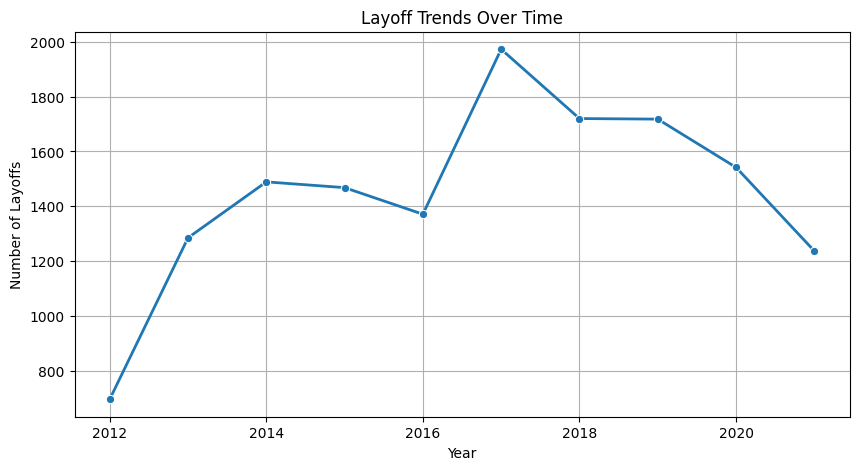

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Layoff Trends Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.groupby('Separation Year').size(), marker='o', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Number of Layoffs")
plt.title("Layoff Trends Over Time")
plt.grid(True)
plt.show()

<ipython-input-7-ac34915d4bce>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_departments.values, y=top_departments.index, palette="Blues_r")


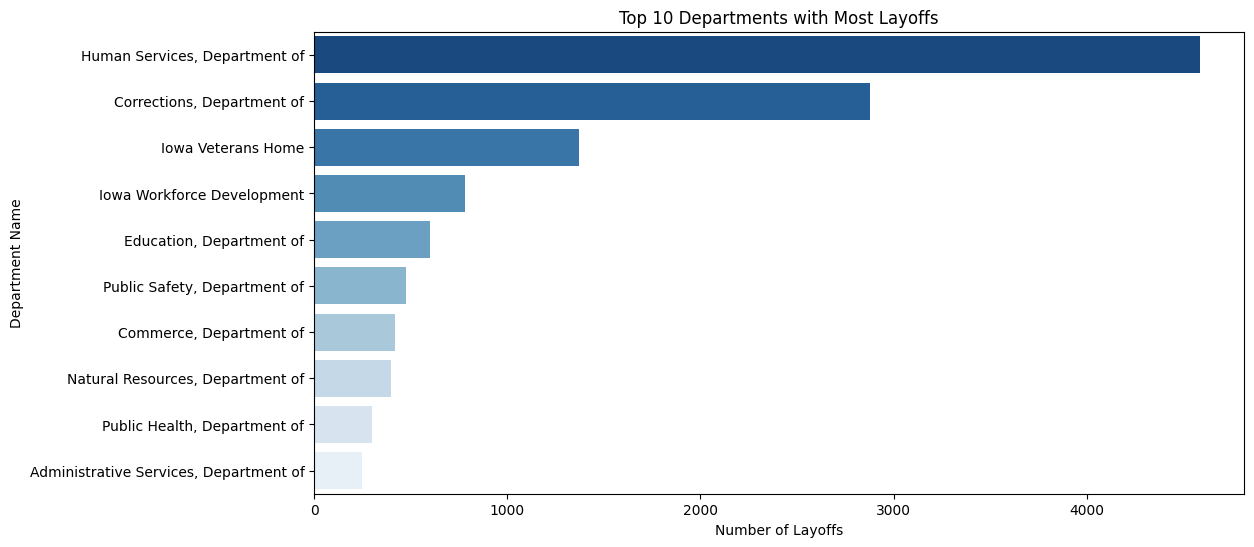

In [7]:
# 2. Department-Wise Layoff Distribution
plt.figure(figsize=(12, 6))
top_departments = df['Department Name'].value_counts().nlargest(10)
sns.barplot(x=top_departments.values, y=top_departments.index, palette="Blues_r")
plt.xlabel("Number of Layoffs")
plt.ylabel("Department Name")
plt.title("Top 10 Departments with Most Layoffs")
plt.show()


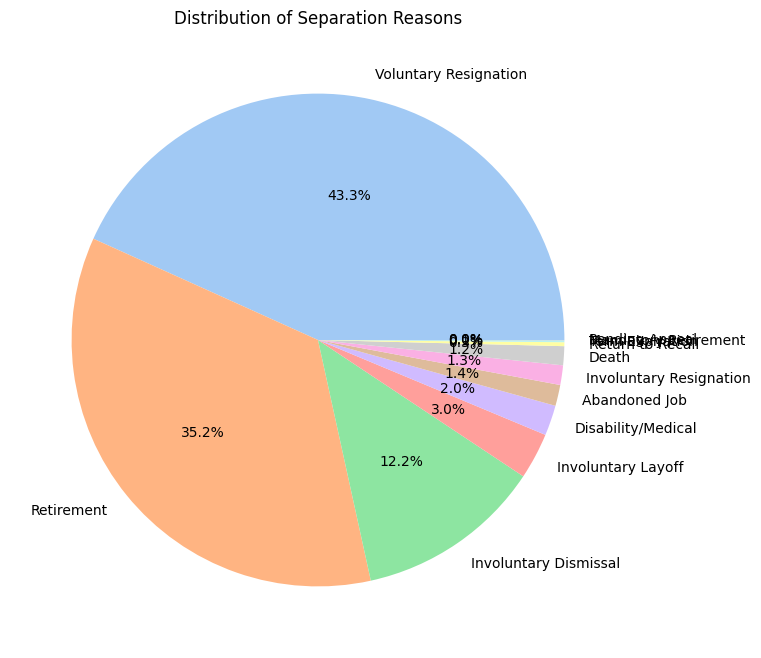

In [13]:
# 3. Separation Reasons Breakdown
plt.figure(figsize=(8, 8))
df['Reason'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.ylabel('')
plt.title("Distribution of Separation Reasons")
plt.show()

In [9]:
df['Reason'].value_counts()

,count
Reason,
Voluntary Resignation,6272
Retirement,5101
Involuntary Dismissal,1773
Involuntary Layoff,441
Disability/Medical,288
Abandoned Job,200
Involuntary Resignation,186
Death,180
Return to Recall,37


In [ ]:
# Label encode the 'Reason' column
label_encoder = LabelEncoder()
df['Reason'] = label_encoder.fit_transform(df['Reason'])


In [ ]:
# One-hot encode categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [ ]:
# Balance the dataset by augmenting minor classes
class_counts = df['Reason'].value_counts()
min_class_count = max(10, class_counts.min())  # Ensure at least 10 samples per class


In [ ]:
df_balanced = pd.DataFrame()
for class_label, count in class_counts.items():
    class_subset = df[df['Reason'] == class_label]
    if count < min_class_count:
        class_subset = resample(class_subset, replace=True, n_samples=min_class_count, random_state=42)
    df_balanced = pd.concat([df_balanced, class_subset])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset


In [ ]:
# Define features and target
X = df_balanced.drop(columns=['Reason'])
y = df_balanced['Reason']


In [ ]:
X.columns

Index(['Record Number', 'Fiscal Year', 'Pay Grade', 'Current Fiscal Year',
       'Separation Year', 'Recent Layoff', 'Employee Status Encoded',
       'EEO_EEO Category Name_Administrative Support',
       'EEO_EEO Category Name_Official/Administrator',
       'EEO_EEO Category Name_Professional',
       ...
       'Pay Period End Date_2021-04-29', 'Pay Period End Date_2021-05-13',
       'Pay Period End Date_2021-05-27', 'Pay Period End Date_2021-06-10',
       'Pay Period End Date_2021-06-24', 'Pay Period End Date_2021-07-08',
       'Pay Period End Date_2021-07-22', 'Pay Period End Date_2021-08-05',
       'Pay Period End Date_2021-08-19', 'Voluntary/Involuntary_Voluntary'],
      dtype='object', length=3726)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = np.zeros((len(y_pred), len(np.unique(y_test))))

    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    return {"AUC": auc, "Precision": precision, "Accuracy": accuracy, "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


### Logistic Regression Model


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg_metrics = evaluate_model(log_reg, X_test_scaled, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Classifier


In [ ]:
pip install joblib

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_clf, X_test, y_test)
import joblib
joblib.dump(rf_clf, "best_layoff_model.pkl")


['best_layoff_model.pkl']

In [ ]:
import joblib

# Save the trained model
joblib.dump(rf_clf, "best_layoff_model.pkl")

# Save the label encoder (
joblib.dump(label_encoder, "label_encoder.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

print("Model, Label Encoder, and Scaler saved successfully!")


Model, Label Encoder, and Scaler saved successfully!


In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load trained model and preprocessing tools
model = joblib.load("best_layoff_model.pkl")
scaler = joblib.load("scaler.pkl")
trained_columns = joblib.load("X_train_columns.pkl")

# Get user input
record_number = int(input("Enter Record Number: "))
fiscal_year = int(input("Enter Fiscal Year: "))
pay_grade = float(input("Enter Pay Grade: "))
separation_year = int(input("Enter Separation Year: "))

# Categorical Inputs
department_name = input("Enter Department Name: ")
sub_unit = input("Enter Sub-Unit of Department: ")
employee_status = input("Enter Employee Status (Permanent/Temporary): ")
pay_plan = input("Enter Pay Plan: ")
classification_title = input("Enter Classification Title: ")
voluntary_status = input("Enter Voluntary/Involuntary Status: ")
eeo_category = input("Enter EEO Category (Administrative Support, Official/Administrator, etc.): ")

# Boolean Inputs
current_fiscal_year = bool(int(input("Is it the Current Fiscal Year? (1 for Yes, 0 for No): ")))
recent_layoff = bool(int(input("Was there a Recent Layoff? (1 for Yes, 0 for No): ")))

# Create an empty DataFrame with the same columns as training
user_data = pd.DataFrame(columns=trained_columns)
user_data.loc[0] = [0] * len(trained_columns)  # Initialize with zeros

# Assign numerical inputs
user_data.at[0, 'Record Number'] = record_number
user_data.at[0, 'Fiscal Year'] = fiscal_year
user_data.at[0, 'Pay Grade'] = pay_grade
user_data.at[0, 'Separation Year'] = separation_year
user_data.at[0, 'Current Fiscal Year'] = current_fiscal_year
user_data.at[0, 'Recent Layoff'] = recent_layoff

# One-hot encode categorical inputs
for col in trained_columns:
    if f'Department Name_{department_name}' == col:
        user_data.at[0, col] = 1
    if f'Sub-Unit of Department_{sub_unit}' == col:
        user_data.at[0, col] = 1
    if f'Employee Status_{employee_status}' == col:
        user_data.at[0, col] = 1
    if f'Pay Plan_{pay_plan}' == col:
        user_data.at[0, col] = 1
    if f'Classification Title_{classification_title}' == col:
        user_data.at[0, col] = 1
    if f'Voluntary/Involuntary_{voluntary_status}' == col:
        user_data.at[0, col] = 1
    if f'EEO_EEO Category Name_{eeo_category}' == col:
        user_data.at[0, col] = 1

# Ensure correct feature order
user_data = user_data[trained_columns]

# Standardize numerical features
user_scaled = scaler.transform(user_data)

# Make Prediction
prediction = model.predict(user_scaled)

# Load label encoder to decode the prediction
label_encoder = joblib.load("label_encoder.pkl")
predicted_reason = label_encoder.inverse_transform(prediction)[0]

# Display Result
print(f"\nPredicted Layoff Reason: **{predicted_reason}**")


Enter Record Number: 10234
Enter Fiscal Year: 2023
Enter Pay Grade: 5.0
Enter Separation Year: 2023
Enter Department Name: Human Resources
Enter Sub-Unit of Department: HR Administration
Enter Employee Status (Permanent/Temporary): Permanent
Enter Pay Plan: General
Enter Classification Title: HR Specialist
Enter Voluntary/Involuntary Status: Voluntary
Enter EEO Category (Administrative Support, Official/Administrator, etc.): Professional
Is it the Current Fiscal Year? (1 for Yes, 0 for No): 1
Was there a Recent Layoff? (1 for Yes, 0 for No): 0

✅ Predicted Layoff Reason: **Retirement**


<ipython-input-50-f8c811f53ea3>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  user_data.at[0, 'Current Fiscal Year'] = current_fiscal_year
<ipython-input-50-f8c811f53ea3>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  user_data.at[0, 'Recent Layoff'] = recent_layoff
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from google.colab import files

# Download the file
files.download("best_layoff_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Extra Trees Classifier


In [ ]:
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_clf.fit(X_train, y_train)
et_metrics = evaluate_model(et_clf, X_test, y_test)


### Gradient Boosting Classifier

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)
gb_metrics = evaluate_model(gb_clf, X_test, y_test)

In [ ]:
# Print model evaluation results
print("Logistic Regression Metrics:", log_reg_metrics)
print("Random Forest Metrics:", rf_metrics)
print("Extra Trees Metrics:", et_metrics)
print("Gradient Boosting Metrics:", gb_metrics)


Logistic Regression Metrics: {'AUC': 0.8897774437402938, 'Precision': 0.735195801140307, 'Accuracy': 0.746900826446281, 'MAE': 1.9118457300275482, 'MSE': 15.668044077134986, 'RMSE': 3.9582880235191307, 'MAPE': inf}
Random Forest Metrics: {'AUC': 0.9138764119612043, 'Precision': 0.7720276040925608, 'Accuracy': 0.8102617079889807, 'MAE': 1.5285812672176309, 'MSE': 12.797865013774105, 'RMSE': 3.5774103781610105, 'MAPE': inf}
Extra Trees Metrics: {'AUC': 0.9088280873849723, 'Precision': 0.7689509022516834, 'Accuracy': 0.8057851239669421, 'MAE': 1.5557851239669422, 'MSE': 13.048209366391184, 'RMSE': 3.61223052508989, 'MAPE': inf}
Gradient Boosting Metrics: {'AUC': 0.9204683620676856, 'Precision': 0.7603988909533183, 'Accuracy': 0.7992424242424242, 'MAE': 1.5946969696969697, 'MSE': 13.332988980716253, 'RMSE': 3.651436563972631, 'MAPE': inf}


In [ ]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

metrics_results = {}

for model_name, model in models.items():
    model.fit(X_train_scaled if "Logistic Regression" in model_name else X_train, y_train)
    metrics_results[model_name] = evaluate_model(model, X_test_scaled if "Logistic Regression" in model_name else X_test, y_test)

# Convert results to DataFrame
metrics_df = pd.DataFrame(metrics_results).T
print(metrics_df)

# Further Analysis
best_model = metrics_df["Accuracy"].idxmax()
print(f"Best model based on accuracy: {best_model}")

# Save results to CSV
metrics_df.to_csv("model_performance_metrics.csv", index=True)
print("Metrics saved to 'model_performance_metrics.csv'")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                          AUC  Precision  Accuracy       MAE        MSE  \
Logistic Regression  0.889777   0.735196  0.746901  1.911846  15.668044   
Random Forest        0.913876   0.772028  0.810262  1.528581  12.797865   
Extra Trees          0.908828   0.768951  0.805785  1.555785  13.048209   
Gradient Boosting    0.920468   0.760399  0.799242  1.594697  13.332989   

                         RMSE  MAPE  
Logistic Regression  3.958288   inf  
Random Forest        3.577410   inf  
Extra Trees          3.612231   inf  
Gradient Boosting    3.651437   inf  
Best model based on accuracy: Random Forest
Metrics saved to 'model_performance_metrics.csv'
